In [1]:

# import random
# import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib nbagg  

# core imports
import os
import sys
import random
import numpy as np


import torch
import gym
import torch.nn as nn

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
# local imports
from autonetwork.environments.single_parameter import TwoParaEnv
from autonetwork.agents.qlearning_agent import QLearningAgent
from autonetwork.simulation import Run, Exploration



interactive = True



In [2]:

env = gym.make('CartPole-v0')

/home/s_bhandari18/workspace/envs/envrl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [33]:
n_state = env.observation_space.shape[0]
n_state

state_dim = env.observation_space.shape
state_dim

(4,)

In [4]:

class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = nn.Sequential(
                        nn.Linear(n_state, n_hidden),
                        nn.ReLU(),
                        nn.Linear(n_hidden, n_action),
                        nn.Softmax(),
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)


    def predict(self, s):
        """
        Compute the action probabilities of state s using the learning model
        """
#         print('s is', s)
        return self.model(torch.Tensor(s))


    def update(self, returns, log_probs):
        """
        Update the weights of the policy network given the training samples
        """
        policy_gradient = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_gradient.append(-log_prob * Gt)

        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def get_action(self, s):
        """
        Estimate the policy and sample an action, compute its log probability
        """
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob




def reinforce(env, estimator, n_episode, gamma=1.0):
    """
    REINFORCE algorithm
    """
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state = env.reset()

        while True:
            # distinguishing state and action
            # action is the selection of hyperparameters,
            # how to represent state at a given run
            # logπ θ (a t |s t )
            # log P (a_t |a_(t−1):1 ; θ c ) : Probability of next action given all used actions?
#             a1,a2,a3 ->a4(predict)
# acccumalated weights(memory) for the next seqeunce generation.
            action, log_prob = estimator.get_action(state)
            next_state, reward, is_done, _ = env.step(action)

            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            rewards.append(reward)

            if is_done:

                returns = []

                Gt = 0
                pw = 0

                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)

                estimator.update(returns, log_probs)
#                 print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))
                break

            state = next_state


# each state :  [position of cart, velocity of cart, angle of pole, rotation rate of pole]
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)


n_episode = 10
gamma = 0.9
total_reward_episode = [0] * n_episode

reinforce(env, policy_net, n_episode, gamma)


<IPython.core.display.Javascript object>


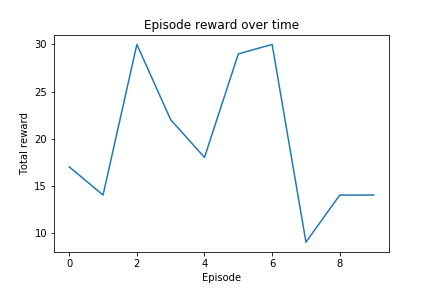

In [5]:

# import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [6]:
R = np.array([[ 1.0596846 ,  1.17167929,  1.29554824,  1.42475069,  1.54497077,
         1.63356644,  1.66666667,  1.63356644,  1.54497077],
       [ 1.20339966,  1.37565631,  1.58952689,  1.84858491,  2.13712604,
         2.39225658,  2.5       ,  2.39225658,  2.13712604],
       [ 1.32392127,  1.56475353,  1.90419384,  2.40679931,  3.17905379,
         4.27425207,  5.        ,  4.27425207,  3.17905379],
       [ 1.37292412,  1.64750894,  2.05938618,  2.74584824,  4.11877236,
         8.23754471, 10.        ,  8.23754471,  4.11877236],
       [ 1.32392127,  1.56475353,  1.90419384,  2.40679931,  3.17905379,
         4.27425207,  5.        ,  4.27425207,  3.17905379],
       [ 1.20339966,  1.37565631,  1.58952689,  1.84858491,  2.13712604,
         2.39225658,  2.5       ,  2.39225658,  2.13712604],
       [ 1.0596846 ,  1.17167929,  1.29554824,  1.42475069,  1.54497077,
         1.63356644,  1.66666667,  1.63356644,  1.54497077],
       [ 0.92429246,  0.99581588,  1.06856302,  1.13766336,  1.19612829,
         1.23585241,  1.25      ,  1.23585241,  1.19612829],
       [ 0.80831307,  0.85485041,  0.89955507,  0.93962739,  0.97176849,
         0.99271203,  1.        ,  0.99271203,  0.97176849]])

<IPython.core.display.Javascript object>


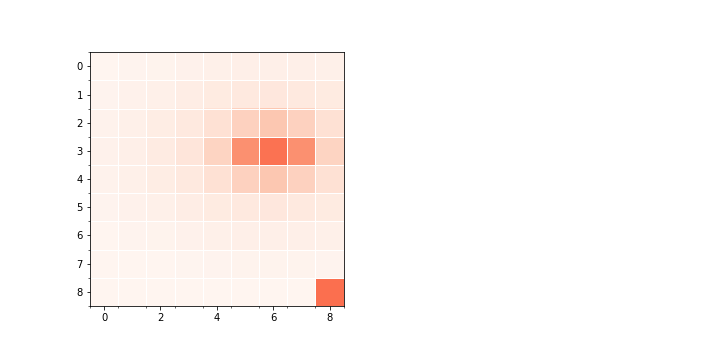

interactive True


/home/s_bhandari18/workspace/envs/envrl/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: 

In [7]:

interactive = True



max_number_of_episodes = 10
env = TwoParaEnv(R)
# agent = QLearningAgent(range(env.action_space.n))

n_state = 2
n_action = env.action_space.n
n_hidden = 128
lr = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

run = Run(env, policy_net)
run.run_reinforce(max_number_of_episodes=max_number_of_episodes, gamma=0.99, interactive = True)
# print(env.observation_space)